In [1]:
import os as os
import re as re
import sys as sys
import numpy as np
import pandas as pd
import math as math
import time as time
import itertools as itertools
import collections as co
import matplotlib
from graph_tool.all import *

In [2]:
def collect_marginals(s):
   global pv
   bs = [gt.perfect_prop_hash([s.b])[0] for s in state.get_levels()]
   pv = [s.collect_vertex_marginals(pv[l], b=bs[l]) for l, s in enumerate(s.get_levels())]

In [3]:
edgeList = pd.read_csv("edges_1.txt", header = 1,
                         sep = " ", names = ["v1", "v2"])
weights = pd.read_csv("mult_1.txt", header = 1,
                         sep = " ", names = ["weight"])

In [4]:
G = Graph()
G.add_edge_list(edgeList.values)

In [5]:
G.ep.weight = G.new_edge_property("double")
# G.list_properties()

for i, e in enumerate(G.edges()):
    G.ep.weight[e] = weights.values[i,0]

#for e in G.edges():
#    print(G.ep.weight[e])

# https://graph-tool.skewed.de/static/doc/quickstart.html#sec-property-maps

In [7]:
# Initial state
state = minimize_blockmodel_dl(G, state_args=dict(recs=[G.ep.weight],
                                                  rec_types=["discrete-binomial"]))
# state.get_B()

# https://graph-tool.skewed.de/static/doc/demos/inference/inference.html?highlight=eorder#edge-weights-and-covariates

In [8]:
# We will first equilibrate the Markov chain
mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))

(524.2251378541933, 1527231, 245333)

In [9]:
# Harvest
pv = None

def collect_marginals(s):
   global pv
   b = perfect_prop_hash([s.b])[0]
   pv = s.collect_vertex_marginals(pv, b=b)

# Now we collect the marginals for exactly 100,000 sweeps, at
# intervals of 10 sweeps:
mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_marginals)

# https://graph-tool.skewed.de/static/doc/demos/inference/inference.html?highlight=eorder#posterior-sampling

(876.0877265190645, 4576770, 733980)

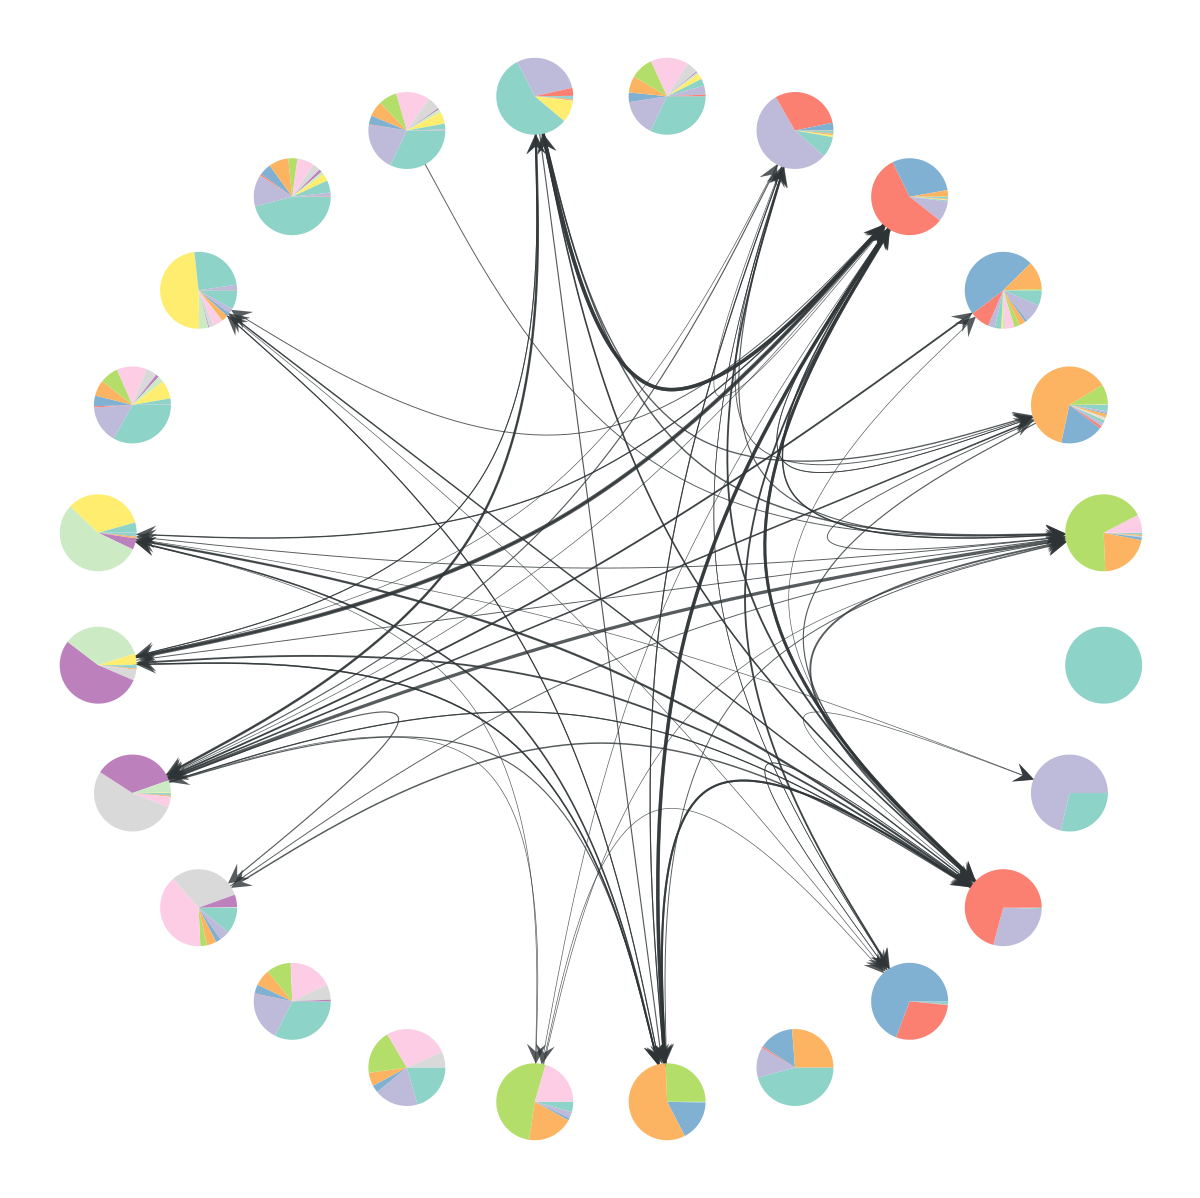

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fce10641670, at 0x7fcdda3d2d90>

In [51]:
t = get_hierarchy_tree(NestedBlockState(G))[0]

tpos = pos = radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
cts = get_hierarchy_control_points(G, t, tpos)
pos = G.own_property(tpos)


state.draw(pos = pos, eorder=G.ep.weight, edge_pen_width=prop_to_size(G.ep.weight), 
           edge_gradient=None, edge_marker_size = 10, edge_control_points=cts,
           vertex_shape="pie", vertex_pie_fractions=pv)

# Radial
## https://graph-tool.skewed.de/static/doc/draw.html?highlight=radial#graph_tool.draw.radial_tree_layout
## https://graph-tool.skewed.de/static/doc/draw.html?highlight=radial

# Pie charts + weights
## https://graph-tool.skewed.de/static/doc/demos/inference/inference.html?highlight=eorder#edge-weights-and-covariates